## **Importing the Necessary Libraries**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.applications import InceptionV3
from tensorflow.keras.applications.inception_v3 import preprocess_input
from tensorflow.keras.preprocessing.image import load_img, img_to_array
import cv2
import seaborn as sns
import os
import shutil
import random
import matplotlib.pyplot as plt

## Spliting the Data Folder to Train, Test, Validation Folders

In [2]:
def split_data(data_dir, save_dir, train_ratio, test_ratio, valid_ratio):
    train_dir = os.path.join(save_dir, 'train')
    valid_dir = os.path.join(save_dir, 'valid')
    test_dir = os.path.join(save_dir, 'test')
    os.makedirs(train_dir, exist_ok=True)
    os.makedirs(valid_dir, exist_ok=True)
    os.makedirs(test_dir, exist_ok=True)

    classes = os.listdir(data_dir)
    for class_name in classes:
        class_dir = os.path.join(data_dir, class_name)

        train_class_dir = os.path.join(train_dir, class_name)
        valid_class_dir = os.path.join(valid_dir, class_name)
        test_class_dir = os.path.join(test_dir, class_name)
        os.makedirs(train_class_dir, exist_ok=True)
        os.makedirs(valid_class_dir, exist_ok=True)
        os.makedirs(test_class_dir, exist_ok=True)

        files = os.listdir(class_dir)
        random.shuffle(files)

        total_files = len(files)
        train_split = int(train_ratio * total_files)
        test_split = int(test_ratio * total_files)

        train_files = files[:train_split]
        test_files = files[train_split:train_split+test_split]
        valid_files = files[train_split+test_split:]

        for file in train_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(train_class_dir, file)
            shutil.copyfile(src, dst)

        for file in test_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(test_class_dir, file)
            shutil.copyfile(src, dst)

        for file in valid_files:
            src = os.path.join(class_dir, file)
            dst = os.path.join(valid_class_dir, file)
            shutil.copyfile(src, dst)

    print('Data split into train, valid, and test directories.')
data_dir = '/kaggle/input/cataractdataset/dataset'
save_dir = '/kaggle/working/'

train_ratio = 0.8
test_ratio = 0.1
valid_ratio = 0.1
split_data(data_dir, save_dir, train_ratio, test_ratio, valid_ratio)

Data split into train, valid, and test directories.


## Visualization of Class Distribution

In [3]:
class_labels = os.listdir(data_dir)

image_counts = []
for label in class_labels:
    class_path = os.path.join(data_dir, label)
    image_count = len(os.listdir(class_path))
    image_counts.append(image_count)

/usr/local/lib/python3.10/dist-packages/seaborn/_oldcore.py:1765: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  order = pd.unique(vector)


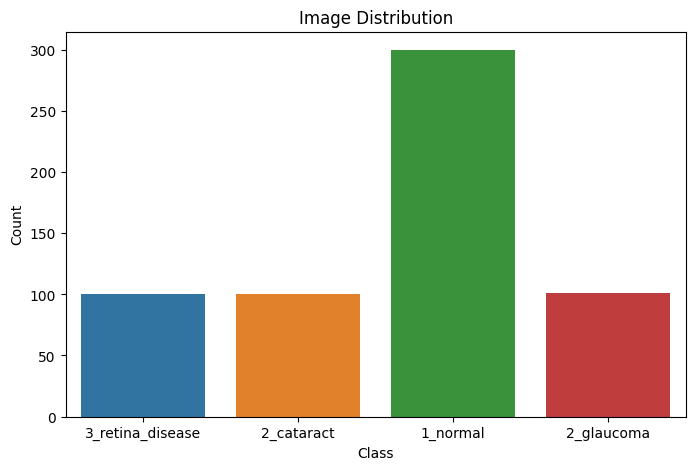

In [4]:
plt.figure(figsize=(8, 5))
sns.barplot(x=class_labels, y=image_counts)
plt.title('Image Distribution')
plt.xlabel('Class')
plt.ylabel('Count')
plt.show()

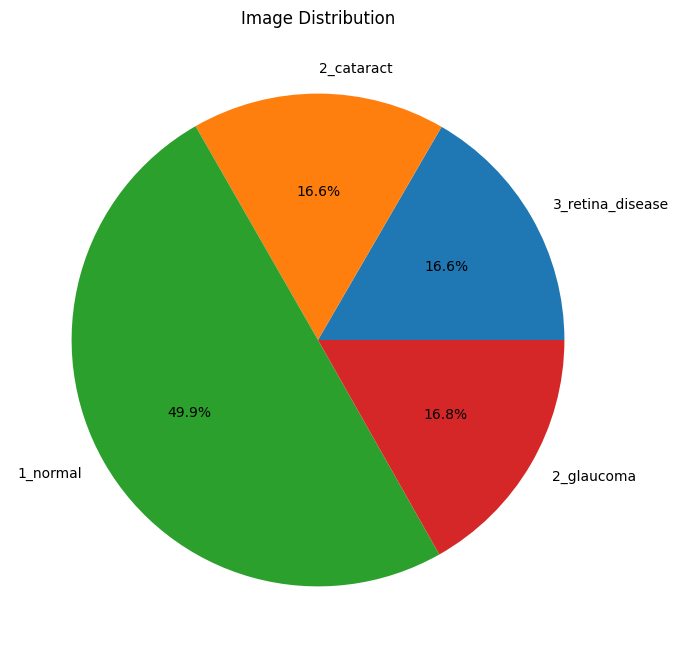

In [5]:
plt.figure(figsize=(8, 8))
plt.pie(image_counts, labels=class_labels, autopct='%1.1f%%')
plt.title('Image Distribution')
plt.show()

## Creating Train Set

In [4]:
train_datagen = ImageDataGenerator(
    rescale = 1./255,
    horizontal_flip = True,
    shear_range = 0.1
)
training_set = train_datagen.flow_from_directory(
    os.path.join(save_dir, 'train'),
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True
)
training_set.class_indices

Found 480 images belonging to 4 classes.


{'1_normal': 0, '2_cataract': 1, '2_glaucoma': 2, '3_retina_disease': 3}

## Creating Test Set

In [5]:
test_datagen = ImageDataGenerator(rescale=1./255)
testing_set = test_datagen.flow_from_directory(
    os.path.join(save_dir, 'test'),
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True
)
testing_set.class_indices

Found 60 images belonging to 4 classes.


{'1_normal': 0, '2_cataract': 1, '2_glaucoma': 2, '3_retina_disease': 3}

## Creating Validation Set

In [6]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_set = validation_datagen.flow_from_directory(
    os.path.join(save_dir, 'valid'),
    target_size = (512, 512),
    batch_size = 32,
    class_mode = 'categorical',
    color_mode = 'rgb',
    shuffle = True
)
validation_set.class_indices

Found 61 images belonging to 4 classes.


{'1_normal': 0, '2_cataract': 1, '2_glaucoma': 2, '3_retina_disease': 3}

## Show Images From Train Set

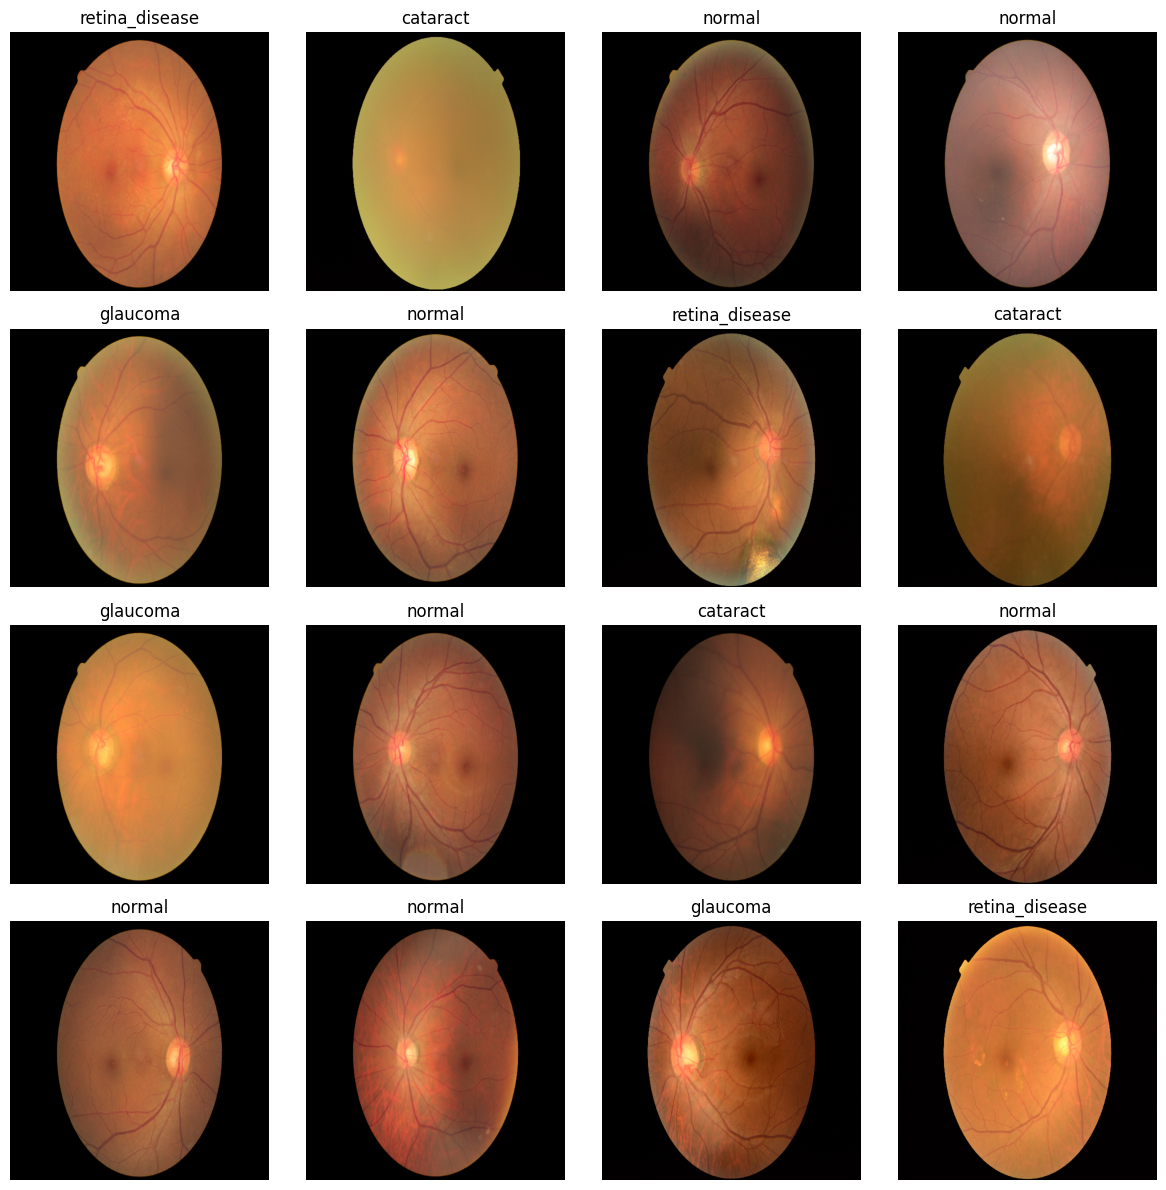

In [9]:
t_img, label = next(training_set)

def plotImages(img_arr, label):
    fig, axes = plt.subplots(4, 4, figsize=(12, 12))
    axes = axes.ravel()

    for i in range(16):
        img = img_arr[i]
        axes[i].imshow(img)
        label_dict = {
            3: 'retina_disease',
            2: 'glaucoma',
            1: 'cataract',
            0: 'normal'
        }
        axes[i].set_title(label_dict[np.where(label[i] == 1)[0][0]])
        axes[i].axis('off')
    plt.tight_layout()
    plt.show()

plotImages(t_img, label)

## Transfer Learning(TL)

In [10]:
base_model = InceptionV3(weights='imagenet', include_top=False, input_shape=(512, 512, 3))
x = base_model.output
x = Conv2D(32, (3, 3), activation='relu')(x)
x = MaxPool2D()(x)
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(4, activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=output)
model.compile(optimizer='adamax', loss='categorical_crossentropy', metrics=['accuracy'])

87910968/87910968 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


## Model Training

In [11]:
history = model.fit(training_set, validation_data=validation_set, epochs=15)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 178s 4s/step - accuracy: 0.3691 - loss: 1.8735 - val_accuracy: 0.4918 - val_loss: 1.2992
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.5287 - loss: 1.0995 - val_accuracy: 0.4918 - val_loss: 1.2707
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6143 - loss: 0.9820 - val_accuracy: 0.4262 - val_loss: 1.3231
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6261 - loss: 0.8840 - val_accuracy: 0.3607 - val_loss: 1.6440
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.6333 - loss: 0.8665 - val_accuracy: 0.4426 - val_loss: 1.3046
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.7022 - loss: 0.7281 - val_accuracy: 0.5082 - val_loss: 1.0018
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.7502 - loss: 0.6099 - val_accuracy: 0.5902 - val_loss: 1.0084
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.7739 - loss: 0.5275 - val_accuracy: 0.7213 - val_loss: 1.0704
Ep

## Plotting Training vs Validation Accuracy and Loss

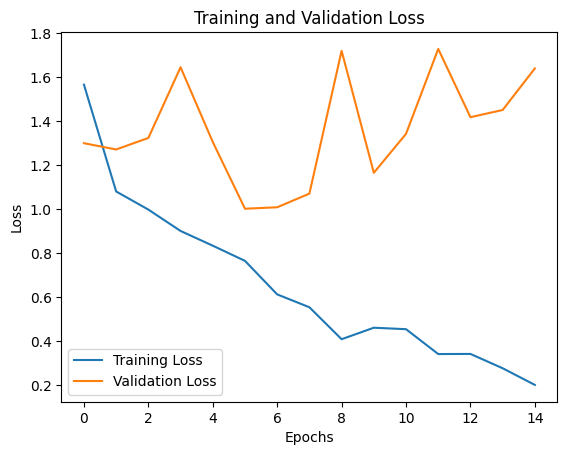

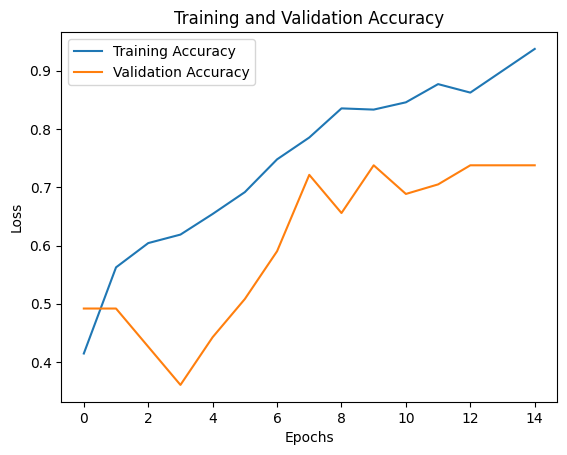

In [12]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Accuracy')
plt.legend()
plt.show()

## Visualizing Feature Maps

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 111ms/step


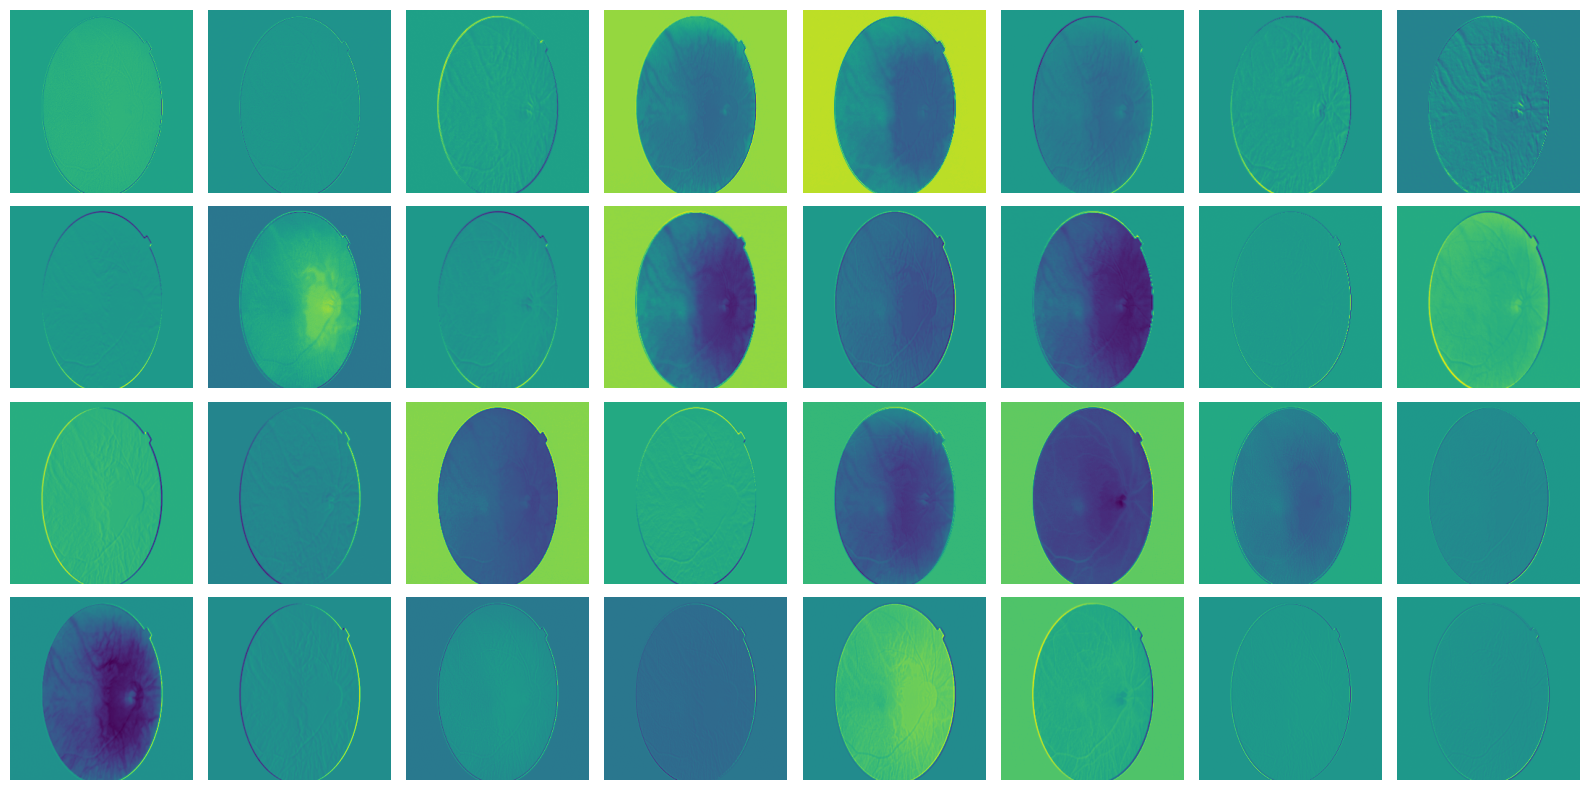

In [27]:
def visualize_activation_maps(model, img_path, layer_name):
    img = load_img(img_path, target_size=(512, 512))
    img_array = img_to_array(img)
    img_array = np.expand_dims(img_array, axis=0)
    img_array = preprocess_input(img_array)

    intermediate_model = Model(inputs=model.input, outputs=model.get_layer(layer_name).output)

    activations = intermediate_model.predict(img_array)

    num_filters = activations.shape[-1]
    rows = int(np.ceil(num_filters / 8))

    fig, axs = plt.subplots(nrows=rows, ncols=8, figsize=(16, rows*2))

    for i in range(rows):
        for j in range(8):
            if i*8 + j < num_filters:
                axs[i, j].imshow(activations[0, :, :, i*8 + j])
                axs[i, j].axis('off')

    plt.tight_layout()
    plt.show()

layer_name = 'conv2d_1'
img_path = '/kaggle/working/valid/2_cataract/cataract_007.png'

visualize_activation_maps(model, img_path, layer_name)

## Model Save

In [17]:
model.save('/kaggle/working/cataract.h5')
model2 = load_model('/kaggle/working/cataract.h5')

## Model Evaluation

In [18]:
train = model.evaluate(training_set)
valid = model.evaluate(testing_set)
test = model.evaluate(validation_set)
print(' ' * 40)
print(' ' * 40)
print("Train Loss: ", train[0])
print("Train Accuracy: ", train[1])
print(' ' * 40)
print(' ' * 40)
print("Validation Loss: ", valid[0])
print("Validation Accuracy: ", valid[1])
print(' ' * 40)
print(' ' * 40)
print("Test Loss: ", test[0])
print("Test Accuracy: ", test[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 58s 4s/step - accuracy: 0.8796 - loss: 0.3813
2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 14s/step - accuracy: 0.6951 - loss: 1.8571
2/2 ━━━━━━━━━━━━━━━━━━━━ 5s 2s/step - accuracy: 0.7626 - loss: 1.6807
                                        
                                        
Train Loss:  0.4284612238407135
Train Accuracy:  0.8770833611488342
                                        
                                        
Validation Loss:  1.989184856414795
Validation Accuracy:  0.6833333373069763
                                        
                                        
Test Loss:  1.6386913061141968
Test Accuracy:  0.7377049326896667


## Error Analysis

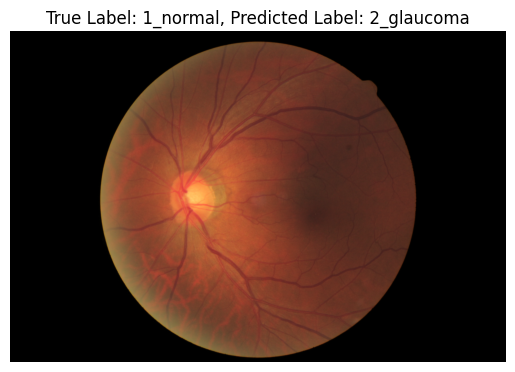

Image Path: /kaggle/working/valid/1_normal/NL_152.png
True Label: 1_normal
Predicted Label: 2_glaucoma
--------------------------------------


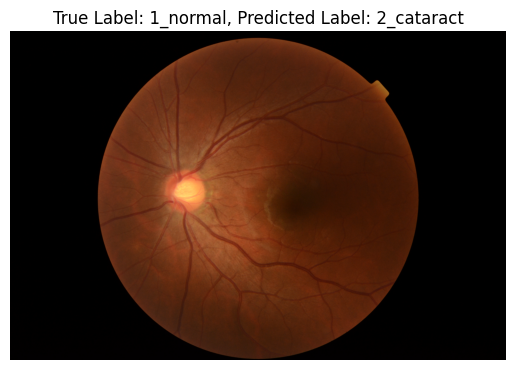

Image Path: /kaggle/working/valid/1_normal/NL_001.png
True Label: 1_normal
Predicted Label: 2_cataract
--------------------------------------


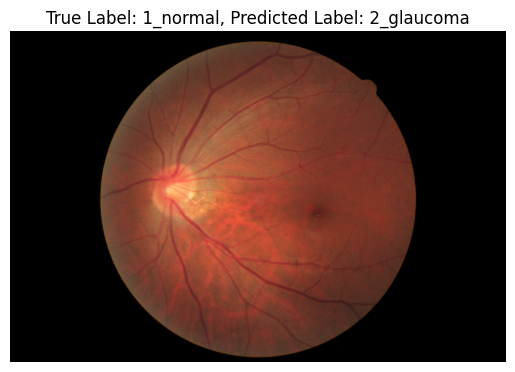

Image Path: /kaggle/working/valid/1_normal/NL_091.png
True Label: 1_normal
Predicted Label: 2_glaucoma
--------------------------------------


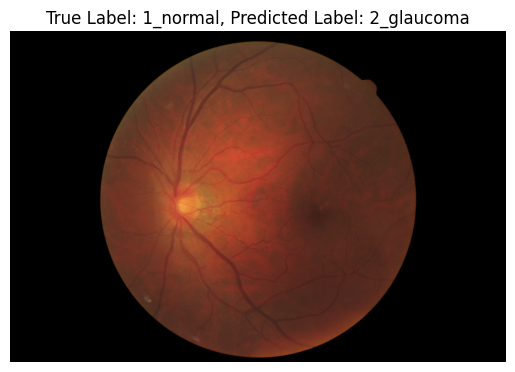

Image Path: /kaggle/working/valid/1_normal/NL_074.png
True Label: 1_normal
Predicted Label: 2_glaucoma
--------------------------------------


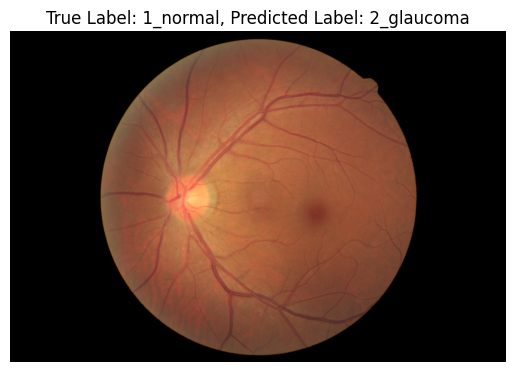

Image Path: /kaggle/working/valid/1_normal/NL_060.png
True Label: 1_normal
Predicted Label: 2_glaucoma
--------------------------------------


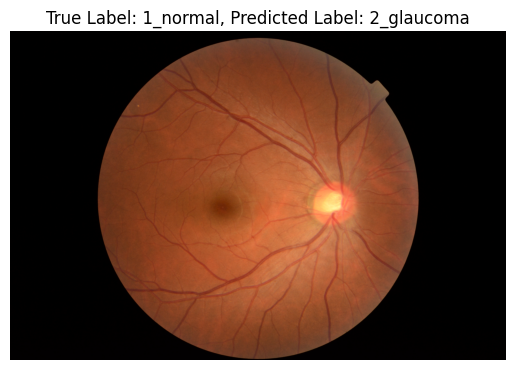

Image Path: /kaggle/working/valid/1_normal/NL_002.png
True Label: 1_normal
Predicted Label: 2_glaucoma
--------------------------------------


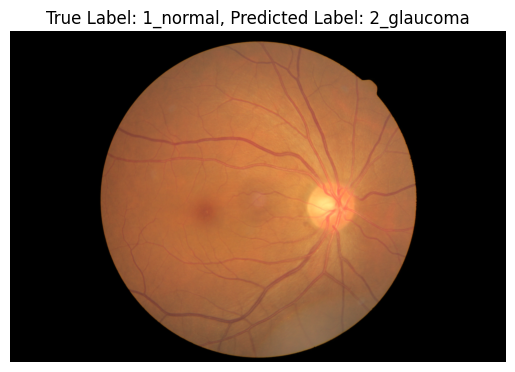

Image Path: /kaggle/working/valid/1_normal/NL_036.png
True Label: 1_normal
Predicted Label: 2_glaucoma
--------------------------------------


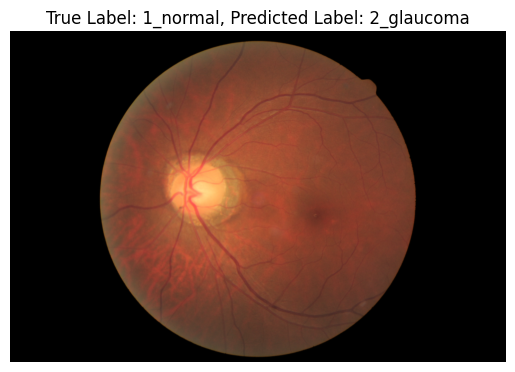

Image Path: /kaggle/working/valid/1_normal/NL_136.png
True Label: 1_normal
Predicted Label: 2_glaucoma
--------------------------------------


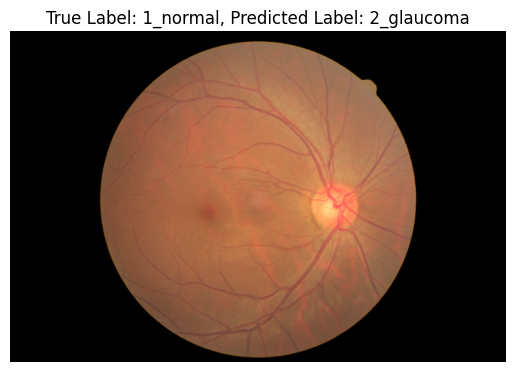

Image Path: /kaggle/working/valid/1_normal/NL_192.png
True Label: 1_normal
Predicted Label: 2_glaucoma
--------------------------------------


In [19]:
data_dir = '/kaggle/working/valid'
class_labels = os.listdir(data_dir)

misclassified_samples = []
for class_label in class_labels:
    class_dir = os.path.join(data_dir, class_label)
    image_files = os.listdir(class_dir)
    for image_file in image_files:
        image_path = os.path.join(class_dir, image_file)
        image = load_img(image_path, target_size=(512, 512))
        input_arr = img_to_array(image)
        input_arr = np.array([input_arr]) / 255.0
        prediction = model.predict(input_arr)
        predicted_class = np.argmax(prediction)
        if predicted_class != class_labels.index(class_label):
            misclassified_samples.append((image_path, class_label, class_labels[predicted_class]))

num_misclassified = 0
for sample in misclassified_samples:
    image_path, true_label, predicted_label = sample
    image = plt.imread(image_path)
    plt.imshow(image)
    plt.title(f'True Label: {true_label}, Predicted Label: {predicted_label}')
    plt.axis('off')
    plt.show()

    # if true_label == predicted_label:
    #     error_type = 'False Positive'
    # else:
    #     error_type = 'False Negative'

    # print(f"Error Type: {error_type}")
    print(f"Image Path: {image_path}")
    print(f"True Label: {true_label}")
    print(f"Predicted Label: {predicted_label}")
    print("--------------------------------------")

    num_misclassified += 1
    if num_misclassified >= 100:
        break

## Predicting an image Using the Model

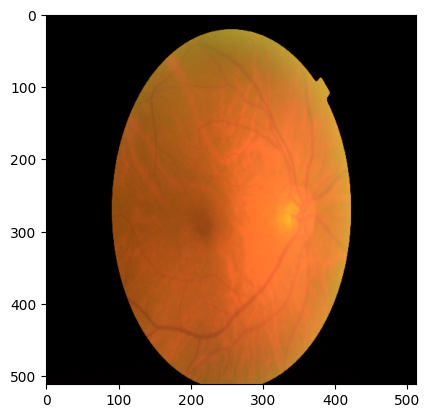

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
cataract


In [20]:
image = load_img('/kaggle/working/valid/2_cataract/cataract_007.png',target_size=(512,512))
plt.imshow(image, cmap='gray')
plt.show()
input_arr = img_to_array(image)
input_arr = np.array([input_arr])
preds = model.predict(input_arr)
y_pred = np.argmax(preds, axis=1)
if y_pred == 3:
    print('retina_disease')
elif y_pred == 2:
    print('glaucoma')
elif y_pred == 1:
    print('cataract')
else:
    print('normal')

## Visualizing Attention Map

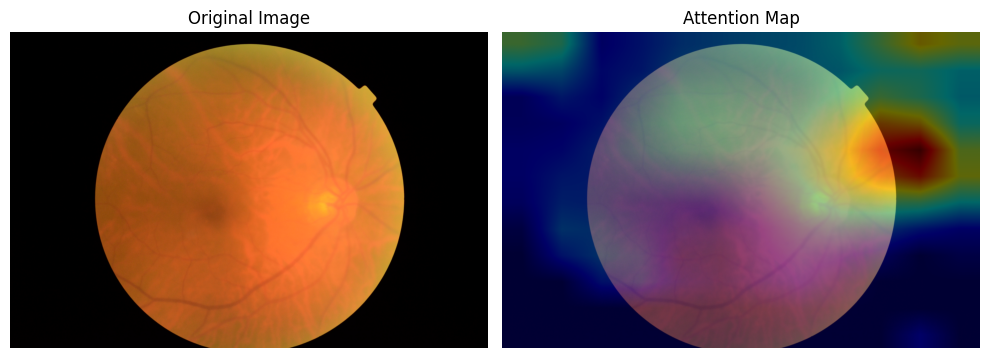

In [25]:
def get_gradcam(model, img_array, layer_name):
    grad_model = Model(
        inputs=[model.inputs],
        outputs=[model.get_layer(layer_name).output, model.output]
    )

    with tf.GradientTape() as tape:
        conv_outputs, predictions = grad_model(img_array)
        class_index = tf.argmax(predictions[0])
        loss = predictions[:, class_index]

    grads = tape.gradient(loss, conv_outputs)
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))
    conv_outputs = conv_outputs[0]

    heatmap = tf.reduce_mean(tf.multiply(pooled_grads, conv_outputs), axis=-1)
    heatmap = np.maximum(heatmap, 0)
    heatmap /= np.max(heatmap)
    return heatmap

def visualize_attention(image_path, heatmap):
    img = cv2.imread(image_path)
    heatmap = cv2.resize(heatmap, (img.shape[1], img.shape[0]))
    heatmap = np.uint8(255 * heatmap)
    heatmap = cv2.applyColorMap(heatmap, cv2.COLORMAP_JET)
    superimposed_img = cv2.addWeighted(img, 0.6, heatmap, 0.4, 0)

    plt.figure(figsize=(10, 6))
    plt.subplot(1, 2, 1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title('Original Image')
    plt.axis('off')

    plt.subplot(1, 2, 2)
    plt.imshow(cv2.cvtColor(superimposed_img, cv2.COLOR_BGR2RGB))
    plt.title('Attention Map')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

image_path = '/kaggle/working/valid/2_cataract/cataract_007.png'
img = tf.keras.preprocessing.image.load_img(image_path, target_size=(512, 512))
img_array = tf.keras.preprocessing.image.img_to_array(img)
img_array = np.expand_dims(img_array, axis=0)
img_array /= 255.0

layer_name = 'conv2d_94'
heatmap = get_gradcam(model, img_array, layer_name)

visualize_attention(image_path, heatmap)

# Convolutional Neural Network

In [7]:
model_cnn = Sequential([
    Input(shape=(512, 512, 3)),
    Conv2D(32, (3, 3), activation='relu'),
    MaxPool2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPool2D(),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPool2D(),
    Conv2D(256, (3, 3), activation='relu'),
    MaxPool2D(),
    Conv2D(512, (3, 3), activation='relu'),
    MaxPool2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(4, activation='softmax')
])
model_cnn.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [8]:
model_cnn.fit(training_set, epochs=15, validation_data=validation_set)

Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


15/15 ━━━━━━━━━━━━━━━━━━━━ 92s 3s/step - accuracy: 0.4403 - loss: 1.8157 - val_accuracy: 0.4918 - val_loss: 1.2495
Epoch 2/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.4714 - loss: 1.2852 - val_accuracy: 0.4918 - val_loss: 1.2861
Epoch 3/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.4845 - loss: 1.2745 - val_accuracy: 0.4918 - val_loss: 1.2683
Epoch 4/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.4928 - loss: 1.2564 - val_accuracy: 0.4918 - val_loss: 1.2515
Epoch 5/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 73s 3s/step - accuracy: 0.5002 - loss: 1.2393 - val_accuracy: 0.4918 - val_loss: 1.2485
Epoch 6/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 72s 3s/step - accuracy: 0.4570 - loss: 1.2891 - val_accuracy: 0.4918 - val_loss: 1.2521
Epoch 7/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.4854 - loss: 1.2484 - val_accuracy: 0.4918 - val_loss: 1.2294
Epoch 8/15
15/15 ━━━━━━━━━━━━━━━━━━━━ 71s 3s/step - accuracy: 0.5372 - loss: 1.1763 - val_accuracy: 0.5246 - val_loss: 1.2110
Epo

In [9]:
train = model_cnn.evaluate(training_set)
valid = model_cnn.evaluate(testing_set)
test = model_cnn.evaluate(validation_set)
print(' ' * 40)
print(' ' * 40)
print("Train Loss: ", train[0])
print("Train Accuracy: ", train[1])
print(' ' * 40)
print(' ' * 40)
print("Validation Loss: ", valid[0])
print("Validation Accuracy: ", valid[1])
print(' ' * 40)
print(' ' * 40)
print("Test Loss: ", test[0])
print("Test Accuracy: ", test[1])

15/15 ━━━━━━━━━━━━━━━━━━━━ 66s 4s/step - accuracy: 0.5789 - loss: 0.9655
2/2 ━━━━━━━━━━━━━━━━━━━━ 10s 6s/step - accuracy: 0.5437 - loss: 1.0592
2/2 ━━━━━━━━━━━━━━━━━━━━ 6s 3s/step - accuracy: 0.6018 - loss: 1.1230
                                        
                                        
Train Loss:  0.9749212265014648
Train Accuracy:  0.5874999761581421
                                        
                                        
Validation Loss:  1.1057322025299072
Validation Accuracy:  0.550000011920929
                                        
                                        
Test Loss:  1.1598334312438965
Test Accuracy:  0.5901639461517334
